In [1]:
import pandas as pd
from tshistory.api import timeseries
import requests, warnings

In [2]:
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')
server = 'https://TST-QDEV-AP1.petroineos.local:5001'

In [3]:
% matplotlib inline

## TSA formulas

In [4]:
# run in saturn environment
def safe_register_formula(tsa, name, formula):
    if tsa.exists(name):
        tsa.delete(name)
    tsa.register_formula(name, formula)

In [5]:
formula = '''
(div
    (time-shifted
        (rolling
            (series "crude.kpler.guyana.oecd_europe.imports.kbd.monthly")
            14)
        #:weeks -2)
    (rolling
        (series "crude.kpler.guyana.exports.kbd.daily" #:fill 0)
        14))'''
name = 'crude.kpler.guyana.exports.oecd_europe.ratio.daily'

In [6]:
safe_register_formula(tsa, name, formula)

AttributeError: 'Client' object has no attribute 'register_formula'

## Argus druzbha

In [ ]:
import requests
import pandas as pd
import io
import os
from pathlib import Path

In [ ]:
def get_publication_date(session, fileid):
    url_get_quote = 'https://direct.argusmedia.com/dataanddownloads/getfiles'
    pdate = [pd.Timestamp(x['date']) for x in session.get(url_get_quote).json() if x['libraryFileId'] == fileid]
    if pdate:
        return pdate[0].floor('D')

def login(session, email, pwd):
    url_login = 'https://myaccount.argusmedia.com/api/login'
    payload = {"Email": email,"Password": pwd}
    resp = session.post(url_login, data=payload)
    import pdb; pdb.set_trace()
    return session

def get_file_content(session, fileid):
    url = f'https://direct.argusmedia.com/DataAndDownloads/DownloadFile/{fileid}'
    return session.get(url).content

In [ ]:
def get_euroilstock_inventories(email, pwd):
    with requests.Session() as session:
        euroilstock_id = 115012
        session = login(session, email, pwd)
        content = get_file_content(session, euroilstock_id)
        pdate = get_publication_date(session, euroilstock_id)
        with io.BytesIO(content) as content:
            data = pd.io.excel.read_excel(content, sheet_name=1, engine='openpyxl', header=4,usecols=range(8))
            cols = data.columns[1:]
            data['pdate'] = pdate
            data['date'] = pd.to_datetime(data.Month, format='%Y-%m-%d')
            data = data.set_index(['pdate', 'date'])[cols].stack().reset_index()
            data.columns = ['pdate', 'date', 'product', 'value']
            data['unit'] = 'mb'
    return pdate, data

In [ ]:
vintage, idata = get_euroilstock_inventories(email, pwd)

In [ ]:
def get_druzbha_flows(email, pwd):
    with requests.Session() as session:
        druzbha_id = 3336
        session = login(session, email, pwd)
        content = get_file_content(session, druzbha_id)
    return content

In [ ]:
email = 'syed.ahmad@petroineos.com'
pwd = 'Syed8126'
# data = get_druzbha_flows(email, pwd)

In [ ]:
url_get_quote = 'https://direct.argusmedia.com/dataanddownloads/getfiles'

In [ ]:
with requests.Session() as session:
    pdate = [pd.Timestamp(x['date']) for x in session.get(url_get_quote).json() if x['libraryFileId'] == fileid]

In [ ]:
pdate_list

In [ ]:
r = requests.get('https://direct.argusmedia.com/DataAndDownloads/DownloadFile/115012', auth=(email, pwd))

In [ ]:
content = r.content

In [ ]:
content

In [ ]:
with io.BytesIO(content) as content:
    data = pd.io.excel.read_excel(content)

## Argus druzbha excel

In [209]:
filepath = 'S:\~Analysis Department\Providers External\Argus\Russian Pipeline Crude exports - 2010 onwards.xlsx'

In [210]:
xls = pd.ExcelFile(filepath)

In [211]:
sheet_list = xls.sheet_names[1:]

In [212]:
m_list = []
for m in sheet_list:
    df = pd.read_excel(xls, sheet_name=m, header=3)
    df.rename(columns={'Exporter':'category'}, inplace=True)
    df_melted = df.melt(id_vars='category')
    df_melted['month'] = m
    m_list.append(df_melted)
all_data = pd.concat(m_list)

In [213]:
all_data['month'] = pd.to_datetime(all_data['month'])
all_data.value = all_data.value.fillna(0)

In [214]:
len(all_data)

246806

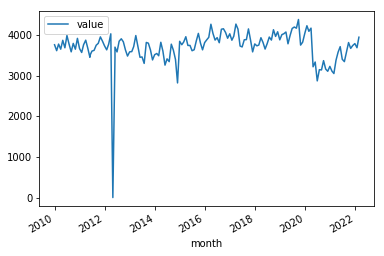

In [215]:
all_data[(all_data['category']=='Total exports by Russia') & (all_data['variable']=="Exports '000 b/d")].plot(x='month', y='value')

In [216]:
total_export_mt = all_data[(all_data['category']=='Total exports by Russia')].copy()

In [217]:
total_export_mt.variable.unique()

array(['Novorossiysk', 'Tuapse', 'Pivdenne', 'Germany', 'Gdansk',
       'Poland', 'Republic', 'Slovakia', 'Hungary', 'Bosnia', 'Kozmino',
       'Primorsk', 'Total exports', "Exports '000 b/d", 'Czech Rep.',
       'Bosina', 'China', 'China (ESPO)', 'China (via Kazakhstan)',
       'North China', 'Ust-Luga', 'Czech Rep', 'Czech Republic'],
      dtype=object)

In [218]:
kbd = total_export_mt[total_export_mt['variable']!="Exports '000 b/d"].copy()

In [219]:
def convert_kbd(df):
    df_new = df.copy()
    df_new.value = df_new.value*7.33
    df_new.value = df_new.value/df.month.dt.daysinmonth
    return df_new

In [220]:
def clean_names(df):
    df_new = df.copy()
    df_new.variable.replace(['Czech Rep.','Czech Rep', 'Republic'], 'Czech Republic', inplace=True)
    df_new.variable.replace(['Bosina'], 'Bosnia', inplace=True)
    df_new.variable.replace(['North China'], 'China (ESPO)', inplace=True)
    df_new.variable.replace(['\)','\('],'', regex=True, inplace=True)
    df_new.variable.replace([' ','-'],'_', regex=True, inplace=True)
    df_new.variable = df_new.variable.str.lower()
    return df_new

In [264]:
total_exp_kbd = clean_names(convert_kbd(total_export_mt))

In [265]:
total_exp_kbd.variable.unique()

array(['novorossiysk', 'tuapse', 'pivdenne', 'germany', 'gdansk',
       'poland', 'czech_republic', 'slovakia', 'hungary', 'bosnia',
       'kozmino', 'primorsk', 'total_exports', "exports_'000_b/d",
       'china', 'china_espo', 'china_via_kazakhstan', 'ust_luga'],
      dtype=object)

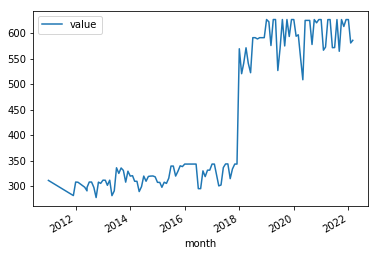

In [223]:
total_exp_kbd[total_exp_kbd['variable']=='china_espo'].plot(x='month', y='value')

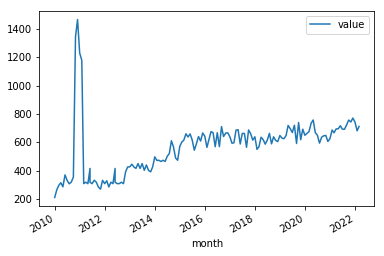

In [225]:
total_exp_kbd[total_exp_kbd['variable']=='kozmino'].plot(x='month', y='value')

In [142]:
country_list = ['novorossiysk', 'tuapse', 'pivdenne', 'germany', 'gdansk','poland', 'czech_republic', 'slovakia', 'hungary', 'bosnia','kozmino', 'primorsk', 'total_exports','china', 'china_espo', 'china_via_kazakhstan', 'ust_luga']

In [230]:
data = total_exp_kbd.drop('category', axis=1).assign(value = lambda x: x.value.astype(float)).groupby(['month', 'variable']).mean()

In [231]:
data[data.duplicated(keep=False)]

value
month      variable                  
2010-01-01 gdansk           96.945161
2010-03-01 gdansk            0.000000
2010-04-01 gdansk           24.433333
2010-05-01 gdansk           47.290323
2010-06-01 czech_republic   95.290000
...                               ...
2022-01-01 poland          120.590323
           slovakia        102.856452
2022-03-01 czech_republic   72.117742
           hungary         121.772581
           poland          125.319355

[299 rows x 1 columns]

In [297]:
def cleaning(df):
    data = df.drop('category', axis=1).assign(value = lambda x: x.value.astype(float)).groupby(['month', 'variable']).mean()
#     data.drop_duplicates(keep=False, inplace=True)
    return data

In [298]:
cleaned_df = cleaning(total_exp_kbd)

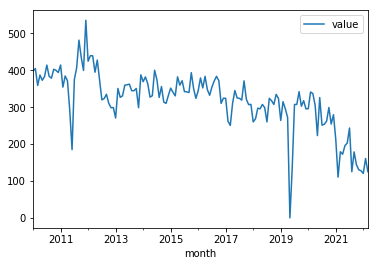

In [325]:
cleaned_df.xs('poland',level=1).plot()

In [319]:
cleaned_df[cleaned_df.duplicated(keep=False)]

value
month      variable                  
2010-01-01 gdansk           96.945161
2010-03-01 gdansk            0.000000
2010-04-01 gdansk           24.433333
2010-05-01 gdansk           47.290323
2010-06-01 czech_republic   95.290000
...                               ...
2022-01-01 poland          120.590323
           slovakia        102.856452
2022-03-01 czech_republic   72.117742
           hungary         121.772581
           poland          125.319355

[299 rows x 1 columns]

In [320]:
pivot = cleaned_df.unstack(1).value

In [321]:
pivot.columns = [f'crude.argus.russia.{c}.pipe_exports.kbd.monthly' for c in pivot.columns]

In [323]:
pivot.to_csv('argus_imports.csv')

In [301]:
for c in country_list:
    name = f'crude.argus.russia.{c}.pipe_exports.kbd.monthly'
    cleaned_df.xs(c,level=1).to_csv(f'{c}_pipeline_imports.csv')
#     tsa.update(name, ts, 'Syed Ahmad')
#     print(ts_temp['value'])
#     print(f'{name} uploaded')

In [204]:
poland = total_exp_kbd[total_exp_kbd['variable']=='poland']['value']

In [205]:
poland

month
2010-01-01    398.303
2010-02-01     404.59
2010-03-01    358.697
2010-04-01    387.048
2010-05-01    372.858
               ...   
2021-11-01    130.613
2021-12-01    127.684
2022-01-01     120.59
2022-02-01    160.998
2022-03-01    125.319
Name: value, Length: 149, dtype: object

In [206]:
poland = poland.astype(float)

In [168]:
germany.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', name='month', length=149, freq=None)

In [169]:
germany[germany.duplicated(keep=False)]

month
2012-06-01    353.557663
2012-11-01    338.098693
2013-06-01    353.557663
2013-11-01    338.098693
Name: value, dtype: float64

In [159]:
type(germany)

pandas.core.series.Series

In [40]:
### doesn't work unknown why
# name = 'crude.argus.russia.poland.pipe_exports.kbd.monthly'
# tsa.update(name, poland, 'Syed Ahmad')

In [158]:
total_exp_kbd[total_exp_kbd.isnull()]

category variable value
month                             
2010-01-01      NaN      NaN   NaN
2010-01-01      NaN      NaN   NaN
2010-01-01      NaN      NaN   NaN
2010-01-01      NaN      NaN   NaN
2010-01-01      NaN      NaN   NaN
...             ...      ...   ...
2022-03-01      NaN      NaN   NaN
2022-03-01      NaN      NaN   NaN
2022-03-01      NaN      NaN   NaN
2022-03-01      NaN      NaN   NaN
2022-03-01      NaN      NaN   NaN

[1983 rows x 3 columns]

In [305]:
bos = pd.read_csv('argus/bosnia_pipeline_imports.csv').set_index('month')

In [306]:
bos[bos.duplicated(keep=False)]

Empty DataFrame
Columns: [value]
Index: []

In [41]:
# ### doesn't work unknown why
# for c in country_list:
#     name = f'crude.argus.russia.{c}.pipe_exports.kbd.monthly'
#     ts = pd.read_csv(f'argus/{c}_pipeline_imports.csv').set_index('month')
#     tsa.update(name, ts['value'], 'Syed Ahmad')
# #     print(ts['value'])
#     print(f'{name} uploaded')